In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/new/temp/shangpinming/tfrecord/seq-basic/vocab.txt', 'vocabulary file')

model_dir='/home/gezi/new/temp/shangpinming/model/seq2seq.attention.loung/'

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

TEXT_MAX_WORDS = 20
INPUT_TEXT_MAX_WORDS = 30

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()
    break


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/new/temp/shangpinming/tfrecord/seq-basic/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
predictor = melt.Predictor(model_dir)

def inference(text):
  predict(predictor, text)

ENCODE_UNK 1
restore from /home/gezi/new/temp/shangpinming/model/seq2seq.attention.loung/model.ckpt-1.8-16000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/shangpinming/model/seq2seq.attention.loung/model.ckpt-1.8-16000


import graph ok /home/gezi/new/temp/shangpinming/model/seq2seq.attention.loung/model.ckpt-1.8-16000.meta
restore ok /home/gezi/new/temp/shangpinming/model/seq2seq.attention.loung/model.ckpt-1.8-16000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [411, 21, 2640, 1733, 232, 93, 18, 324, 196, 7, 2035, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 30
美国/代购/Vaseline/凡士林/深层/滋润/保湿/修复/护手/霜/护甲
美国/代购/Vaseline/凡士林/深层/滋润/保湿/修复/护手/霜/护甲
0 [475, 6, 250, 3, 1710, 196, 7, 2] Shiseido///资生堂/ /六角/护手/霜/<EOS> 0.00056663388041 -7.4758 -7.4758 [-3.4238067, -0.00031168372, -0.38529739, -0.0089870952, -1.7798713, -1.6164799, -0.04497052, -0.21607277]


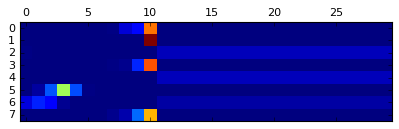

beam search using time(ms): 1364.51601982


In [8]:
inference('美国代购Vaseline凡士林深层滋润保湿修复护手霜护甲')

word_ids [172, 1310, 1959, 7789, 169, 8127, 9039, 732, 140, 717, 11, 124, 259, 6, 231, 259, 3, 157, 259, 3, 310, 452, 77, 732, 231, 259, 3, 215, 259, 3] len: 30
【/京/东/超市/】/巴巴/罗莎/（/<UNK>/）/膏/体/刷///眼线/刷/ /化妆/刷/ /1/支/装/（/眼线/刷/ /眼影/刷/ 
【/京/东/超市/】/巴巴/罗莎/（/<UNK>/）/膏/体/刷///眼线/刷/ /化妆/刷/ /1/支/装/（/眼线/刷/ /眼影/刷/ 
0 [419, 754, 6, 386, 123, 3, 286, 218, 7, 2] Lan/WHASOO///雪花/秀/ /气垫/BB/霜/<EOS> 8.52376264654e-05 -9.37007 -9.37007 [-2.9033961, -1.7959862, -6.5920562e-05, -1.01689, -0.050225165, -0.003036652, -2.6602082, -0.6805672, -0.13194908, -0.12774366]


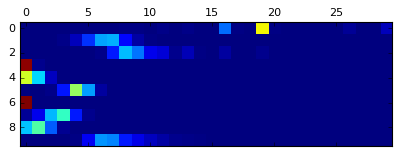

beam search using time(ms): 645.710945129


In [9]:
inference('【京东超市】巴巴罗莎（babaluosha）膏体刷/眼线刷 化妆刷 1支装（眼线刷 眼影刷 唇刷 刷子 美妆工具）')

word_ids [1109, 444, 291, 4356, 1124, 3, 1669, 975, 101, 4069, 488, 3, 1052, 4356, 9, 22, 1441, 3, 684, 345, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 30
卡姿兰/彩妆/套装/全套/组合/ /初学/者/化/淡妆/裸妆/ /含/全套/美/妆/工具/ /清新/自然/款
卡姿兰/彩妆/套装/全套/组合/ /初学/者/化/淡妆/裸妆/ /含/全套/美/妆/工具/ /清新/自然/款
0 [351, 3, 702, 3, 670, 3, 519, 6, 129, 3, 360, 2] The/ /history/ /of/ /whoo///后/ /拱/<EOS> 3.70271426464e-05 -10.2039 -10.2039 [-2.9233749, -0.27031997, -1.013133, -0.025920447, -0.63702857, -0.033347305, -0.28265205, -0.006806877, -0.088601515, -0.022948055, -1.2687218, -3.6310039]


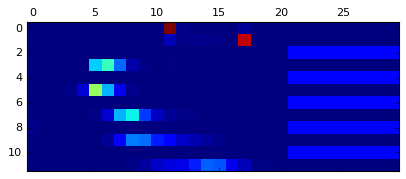

beam search using time(ms): 635.992050171


In [10]:
inference('卡姿兰彩妆套装全套组合 初学者化淡妆裸妆 含全套美妆工具 清新自然款')